In [17]:
import numpy as np
from getdist.mcsamples import loadMCSamples, MCSamples
from getdist import plots
import matplotlib.pyplot as plt
%matplotlib inline
from classy_sz import Class as Class_sz

In [18]:
%%time
cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66, # use H0 because this is what is used by the emulators.
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665,
}

# initialize computation
classy_sz = Class_sz()
classy_sz.set(cosmo_params)
classy_sz.set({
'output':' ',
'jax': 1,
})
classy_sz.compute_class_szfast()

CPU times: user 3.03 ms, sys: 12 µs, total: 3.04 ms
Wall time: 2.82 ms


In [19]:
# Define chain directory
# chain_dir = r'/Users/licongxu/Work/tszpower/chains/tszpower_chain'
chain_dir = r'/data/vault/lx256/tsz_project/tszpower/chains_newest/tszpower_chain'

# Load MCMC samples
readsamps_MH = loadMCSamples(chain_dir)
p = readsamps_MH.getParams()
print('Adding derived parameters')

# Compute sigma8 for each sample
sigma8_values = []
for i in range(len(p.ln10_10A_s)):
    logA = p.ln10_10A_s[i]
    omega_cdm = p.omega_cdm[i]
    # omega_b = p.omega_b[i]
    H0 = p.H0[i]
    # n_s = p.n_s[i]
    cosmo_params = {
        'omega_b': 0.0224,
        'omega_cdm': omega_cdm,
        'H0': H0,
        'ln10^{10}A_s': logA,
        'n_s': 0.965,
    }

    A_s_dict = cosmo_params
    sigma8 = classy_sz.get_sigma8_and_der(params_values_dict=A_s_dict)[1]  # Compute sigma8
    sigma8_values.append(sigma8)

# Convert list to numpy array
sigma8_values = np.array(sigma8_values)

# Add derived parameters to MCMC samples
readsamps_MH.addDerived(sigma8_values, name='sigma8', label=r'\sigma_8')
# Compute derived parameter: ln(1/A_rs)
ln_1_A_rs = np.log(1.0 / p.A_rs)

# Add derived parameter to samples
readsamps_MH.addDerived(ln_1_A_rs, name='ln_1_A_rs', label=r'\ln(1/A_\mathrm{rs})')
print("Derived parameters added successfully.")

Adding derived parameters
Derived parameters added successfully.


In [20]:
# Define chain directory
# chain_dir = r'/Users/licongxu/Work/tszpower/chains/tszpower_chain'
# chain_dir = r'/Users/licongxu/Desktop/chains/tszpower_chain'
samples_dir = r"/data/vault/lx256/tsz_project/tszpower/samples_nle/samples_NLE5t1000.txt"
# samples_dir = r"/data/vault/lx256/tsz_project/tszpower/samples_npe/samples_NPE_10k_and_10k.txt"
# samples_dir = r"/data/vault/lx256/tsz_project/tszpower/samples_nre/samples_NRE_3000.txt"
data = np.loadtxt(samples_dir, skiprows=0)
# Define the parameter names and (optional) pretty labels:
names = ['logA', 'omega_b', 'omega_cdm', 'H0', 'n_s', 'B', 'A_cib', 'A_rs', 'A_ir']
labels = [r'\logA', r'\omega_b', r'\omega_{cdm}', r'H_0', r'n_s', r'B', r'A_{\rm cib}', r'A_{\rm rs}', r'A_{\rm ir}']

# Load MCMC samples
# ignore_row = 0.5
readsamps_SBI = MCSamples(samples = data, names=names, labels=labels)
print(readsamps_SBI.samples)
print(readsamps_SBI.getParamNames())

Removed no burn in
[[2.94771194 0.02419281 0.12986246 ... 0.32099301 0.07010464 2.10718679]
 [2.94155002 0.02313502 0.12982288 ... 0.28772619 0.30566815 2.05589795]
 [2.95205665 0.02442217 0.1296249  ... 0.28844881 0.84533477 1.81363964]
 ...
 [3.37368822 0.02011742 0.12045129 ... 0.19045739 0.11587614 1.97823358]
 [3.35202217 0.02084658 0.12181551 ... 0.29190457 0.22380061 1.66293371]
 [3.36885381 0.02350044 0.1228995  ... 0.33821023 0.29626462 1.63216817]]
logA	\logA
omega_b	\omega_b
omega_cdm	\omega_{cdm}
H0	H_0
n_s	n_s
B	B
A_cib	A_{\rm cib}
A_rs	A_{\rm rs}
A_ir	A_{\rm ir}



In [21]:
# Compute h and Omega_m for each sample
h = p.H0 / 100.0  # Compute h
omega_b = 0.0224
Omega_m = (p.omega_cdm + omega_b) / h**2  # Compute Omega_m

# Compute F = sigma8 * (Omega_m / B)^0.40 * h^-0.21
F_values = sigma8_values * (Omega_m / p.B) ** 0.40 * h ** -0.21

# Add F as a derived parameter
readsamps_MH.addDerived(F_values, name='F', label=r'F = \sigma_8 (\Omega_m / B)^{0.40} h^{-0.21}')

# **Force GetDist to recognize the new parameter**
readsamps_MH.updateBaseStatistics()

print("Derived parameter F added successfully.")


Derived parameter F added successfully.


In [22]:
p = readsamps_SBI.getParams()
print('Adding derived parameters')

# Compute sigma8 for each sample
sigma8_values = []

for i in range(len(p.logA)):
    logA = p.logA[i]
    omega_cdm = p.omega_cdm[i]
    omega_b = p.omega_b[i]
    H0 = p.H0[i]
    n_s = p.n_s[i]
    cosmo_params = {
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'H0': H0,
        'ln10^{10}A_s': logA,
        'n_s': n_s,
    }

    A_s_dict = cosmo_params
    sigma8 = classy_sz.get_sigma8_and_der(params_values_dict=A_s_dict)[1]  # Compute sigma8
    sigma8_values.append(sigma8)


# Convert list to numpy array
sigma8_values = np.array(sigma8_values)

# Add derived parameters to MCMC samples
readsamps_SBI.addDerived(sigma8_values, name='sigma8', label=r'\sigma_8')
# Compute derived parameter: ln(1/A_rs)
ln_1_A_rs = np.log(1.0 / p.A_rs)

# Add derived parameter to samples
readsamps_SBI.addDerived(ln_1_A_rs, name='ln_1_A_rs', label=r'\ln(1/A_\mathrm{rs})')

# Compute h and Omega_m for each sample
h = p.H0 / 100.0  # Compute h
Omega_m = (p.omega_cdm + p.omega_b) / h**2  # Compute Omega_m

# Compute F = sigma8 * (Omega_m / B)^0.40 * h^-0.21
F_values = sigma8_values * (Omega_m / p.B) ** (0.40) * h ** (-0.21)

# Add F as a derived parameter
readsamps_SBI.addDerived(F_values, name='F', label=r'F = \sigma_8 (\Omega_m / B)^{0.40} h^{-0.21}')

# **Force GetDist to recognize the new parameter**
readsamps_SBI.updateBaseStatistics()

print("Derived parameter F added successfully.")

print("Derived parameters added successfully.")

Adding derived parameters
Derived parameter F added successfully.
Derived parameters added successfully.


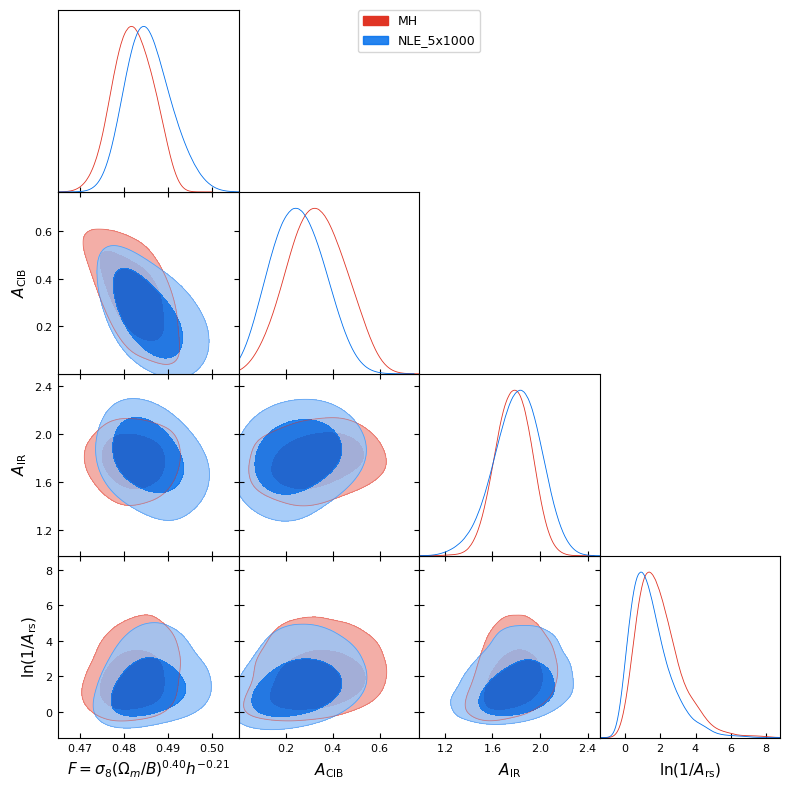

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
from getdist import plots  # make sure you've imported the necessary module

# Define parameters to plot
params_to_plot = ['F', 'A_cib', 'A_ir', 'ln_1_A_rs']

# Create the subplot plotter
g = plots.get_subplot_plotter()

# Plot both samples with a legend. The two samples will automatically be assigned different colors.
g.triangle_plot([readsamps_MH, readsamps_SBI],
                params_to_plot,
                filled=True,
                legend_labels=['MH', 'NLE_5x1000'])

# Optionally, adjust axis limits for specific parameters (if needed)
# g.subplots[0, 0].set_xlim(0.42, 0.52)   # Adjust x-axis limit for 'F'
# g.subplots[1, 1].set_xlim(0, 1)           # Adjust x-axis limit for 'A_cib'
# g.subplots[2, 2].set_xlim(1.5, 2.5)         # Adjust x-axis limit for 'A_ir'
# g.subplots[3, 3].set_xlim(-1.5, 6)          # Adjust x-axis limit for 'ln_1_A_rs'

# Display the plot
plt.show()
